In [1]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
plt.rcParams['svg.fonttype'] = 'none'

nano_ladder = [25,200,500,1000,2000,4000,6000] # they just do linear fit

## Read in and plot ladder information

In [2]:
ladder_data = []
for ladder_file in glob('data_export/*Ladder-peaks.csv'):
    ladder = pd.read_csv(ladder_file)
    ladder_top6 = ladder.sort_values('Time corrected area',ascending = False).head(7)['Aligned Migration Time [s]'].sort_values().to_list()
    for time,nt in zip(ladder_top6,nano_ladder):
        ladder_data.append([ladder_file,1/time,nt])
ladder_data = pd.DataFrame(ladder_data,columns = ['ladder_file', 'inverse_migration_time_s', 'length_nt'])

data_export/Eukaryote Total RNA Nano_2023-12-07_15-03-29_Ladder-peaks.csv
-0.011622864915385629 0.06121212439684324 -0.9990573119632992 5.237867043400352e-08 0.0002258574424183162
log(nt) = -86.04((1/time)-0.0612)
data_export/Eukaryote Total RNA Nano_2024-04-02_15-17-51_Ladder-peaks.csv
-0.01155777299192757 0.06104726925690548 -0.999342227953112 2.1305381774954705e-08 0.0001875668974930757
log(nt) = -86.52((1/time)-0.061)
data_export/Eukaryote Total RNA Nano_2024-04-17_12-58-50_Ladder-peaks.csv
-0.011604048015070596 0.061161197687038954 -0.9992236328273593 3.2243419789068766e-08 0.00020460963858015663
log(nt) = -86.18((1/time)-0.0612)


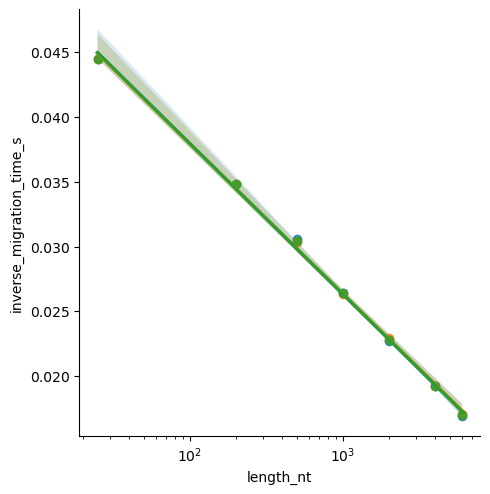

In [3]:
sns.lmplot(ladder_data,y='inverse_migration_time_s',x='length_nt',hue='ladder_file',legend=False,logx=True)
plt.gca().set_xscale('log')
ladder_dict = {}
for file,df in ladder_data.groupby('ladder_file'):
    print(file)
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(df['length_nt']),df['inverse_migration_time_s'])
    print(slope, intercept, r_value, p_value, std_err)
    print(f'log(nt) = {(1/slope).round(2)}((1/time)-{intercept.round(4)})')
    ladder_dict[file.replace('\\','/')[:-17]] = (1/slope,intercept)

## Read in the sample info and save list of these

In [4]:
info_data = []
for info_file in glob('data_export/*Sample-Info.csv'):
    info_file = info_file.replace('\\','/')
    info = pd.read_csv(info_file)
    for i,name in enumerate(info.iloc[:12,0]):
        info_data.append([name,info_file[:-16],i+1])
info_data = pd.DataFrame(info_data,columns = ['sample_name', 'run_name', 'run_index'])

In [5]:
info_data.to_csv('bioanalyzer_locations_summary_RAW.csv', index=False)
info_data

,sample_name,run_name,run_index


## Plot the gels

In [6]:
bioanlyzer_data = pd.read_csv('bioanalyzer_locations_summary.csv')

for ind,row in bioanlyzer_data.iterrows():
    if row.length != row.length:
        continue
    slope,intercept = ladder_dict[row.run_name]
    data = pd.read_csv(f'{row.run_name}_Sample{row.run_index}.csv',header=13)[:-1].astype(float).sort_values('Time',ascending=False)
    data['log(nt)'] = slope*((1/data.Time)-intercept)
    data['nt'] = 10**data['log(nt)']
    data['name'] = row.sample_name
    lad = pd.read_csv(f'{row.run_name}_Ladder.csv',header=13)[:-1].astype(float).sort_values('Time',ascending=False)
    lad['log(nt)'] = slope*((1/lad.Time)-intercept)
    lad['nt'] = 10**lad['log(nt)']
    lad['name'] = 'Ladder'
    data = pd.concat([lad,data]).reset_index()
    data = data.pivot_table(index="nt", columns="name", values="Value",sort=False)
    data = data.reindex(columns=['Ladder',row.sample_name])
    yticks = [0,10,20,30,40,50,60,70,80,90,100,
              200,300,400,500,600,700,800,900,1000,
             2000,3000,4000,5000,6000,7000,8000,9000,10000]
    yticks_lab = ['','','','','','','','','','',100,
                 '','','','','','','','',1000,
                 '','','','','','','','',10000,]
    yticks_loc = [(data.reset_index()['nt']-x).abs().argsort()[0] for x in yticks]
    plt.imshow(data,aspect=0.01,interpolation='none',cmap='Greys',vmax=100)
    length_rna_converted = (data.reset_index()['nt']-row.length).abs().argsort()[0] 
    #plt.hlines(length_rna_converted,1.5,2.5,linewidth=4)
    plt.text(1.55,length_rna_converted,f'{int(row.length)} nt',va='center')
    t=plt.yticks(yticks_loc,yticks_lab)
    plt.gca().spines[['right', 'top']].set_visible(False)
    t = plt.xticks([0,1],['Ladder',row.sample_name],
                   rotation=90,size=8)
    standard = (data.reset_index()['nt']-25).abs().argsort()[0] 
    plt.hlines(standard,-0.5,1.5)
    # save without
    plt.savefig(f'{row.sample_name}__{row.run_name.split("Nano_")[1]}.svg')
    #for i in range(2,7):
    #    length_rna_converted = (data.reset_index()['nt']-(i*row.length)).abs().argsort()[0] 
    #    plt.text(1.55,length_rna_converted,f'{i}-mer',va='center',size=8)
    #plt.savefig(f'{row.sample_name}__{row.run_name.split("Nano_")[1]}.svg')
    #plt.savefig(f'gel_plots/{row.sample_name}__{row.run_name.split("Nano_")[1]}.png')
    plt.clf()

<Figure size 640x480 with 0 Axes>